In [ ]:
%load_ext autoreload
%autoreload 2

# Visualise motifs NFBLB and IFFLP

In [ ]:
import seaborn as sns
from evoscaper.utils.visualise import create_network_inset, make_nx_weights

# Protein-actuator motifs

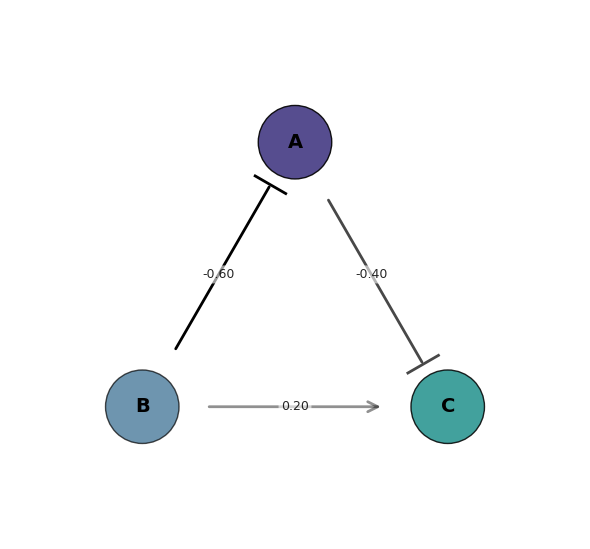

In [ ]:
#!/usr/bin/env python3
"""
draw_3node_network.py

Visualise a 3-node biochemical reaction network.
Nodes: 'A', 'B', 'C' with specified colors and alpha (transparency).
Edges: matrix m (3x3) where positive = activation (arrowhead),
       negative = repression (flat T-bar). Edge opacity ~ |m_ij|.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.lines import Line2D

def normalize_strengths(m, min_alpha=0.15, max_alpha=1.0):
    """Map absolute strengths to opacity in [min_alpha, max_alpha]."""
    flat = np.abs(m).flatten()
    if np.all(flat == 0):
        return np.zeros_like(m) + min_alpha
    lo, hi = flat.min(), flat.max()
    if lo == hi:
        # all nonzero equal -> map nonzeros to max_alpha, zeros to min_alpha
        out = np.where(m == 0, min_alpha, max_alpha)
        return out
    norm = (np.abs(m) - lo) / (hi - lo)
    return min_alpha + (max_alpha - min_alpha) * norm

def circular_positions(n=3, radius=1.8, center=(0,0)):
    """Return n positions on a circle (x,y) for layout, in consistent order."""
    cx, cy = center
    angles = np.linspace(0, 2*np.pi, n, endpoint=False) + np.pi/2  # start at top
    return {i: (cx + radius*np.cos(a), cy + radius*np.sin(a)) for i, a in enumerate(angles)}

def shorten_edge(p_from, p_to):
    node_radius = 0.2
    padding = 0.0  # small extra gap between node border and edge
    offset = node_radius + padding
    start = shorten_point(p_from, p_to, offset)
    end = shorten_point(p_to, p_from, offset)
    return start, end

def draw_activation(ax, p_from, p_to, opacity, linewidth=2.0, color='k'):
    """Draw an activation arrow from p_from -> p_to using FancyArrowPatch."""

    start, end = shorten_edge(p_from, p_to)

    x1, y1 = start
    x2, y2 = end
    # shrink the arrow so it doesn't overlap node circles (node radius ~0.25)
    shrink = 0.27
    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='->',  # pointed arrow
        mutation_scale=18,
        linewidth=linewidth,
        color=color,
        alpha=opacity,
        shrinkA=shrink*100, shrinkB=shrink*100,
        connectionstyle="arc3,rad=0.0"
    )
    ax.add_patch(arrow)

def draw_repression(ax, p_from, p_to, opacity, linewidth=2.0, color='k'):
    """Draw repression: a straight line plus a small perpendicular T-bar near the target."""
    
    start, end = shorten_edge(p_from, p_to)

    x1, y1 = start
    x2, y2 = end
    # draw main line (no arrow head)
    line = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='-',  # plain line
        linewidth=linewidth,
        color=color,
        alpha=opacity,
        shrinkA=0.27*100, shrinkB=0.16*100,  # leave space for T-bar
        connectionstyle="arc3,rad=0.0"
    )
    ax.add_patch(line)

    # compute location for T-bar: a short distance from target along the line
    # position at t fraction along line (0=start, 1=end)
    t = 0.92
    xt = x1 + t*(x2 - x1)
    yt = y1 + t*(y2 - y1)

    # direction vector
    dx = x2 - x1
    dy = y2 - y1
    L = np.hypot(dx, dy)
    if L == 0:
        return
    # unit perpendicular vector
    ux = -dy / L
    uy = dx / L
    bar_half = 0.12  # half-length of T-bar
    x_left = xt - ux*bar_half
    y_left = yt - uy*bar_half
    x_right = xt + ux*bar_half
    y_right = yt + uy*bar_half

    # draw T-bar
    ax.add_line(Line2D([x_left, x_right], [y_left, y_right], linewidth=linewidth, color=color, alpha=opacity))

def shorten_point(p_from, p_to, offset):
    """Move the point p_from toward p_to by 'offset' (in data coords)."""
    x1, y1 = p_from
    x2, y2 = p_to
    dx = x2 - x1
    dy = y2 - y1
    L = np.hypot(dx, dy)
    if L == 0:
        return p_from
    t = offset / L
    # ensure not moving past the other point
    t = min(max(t, 0.0), 0.499)
    return (x1 + dx * t, y1 + dy * t)

def draw_network(m, node_names=None, node_colors=None, node_alpha=None, figsize=(6,6), title=None):
    """
    Draw the 3-node network specified by matrix m (3x3 numpy array).
    m[i,j] is influence from node i -> node j (positive activation, negative repression).
    """
    assert m.shape == (3,3), "m must be 3x3"
    if node_names is None:
        node_names = ['A','B','C']
    if node_colors is None:
        node_colors = ['tab:blue', 'tab:orange', 'tab:green']
    if node_alpha is None:
        node_alpha = [1.0, 1.0, 1.0]

    pos = circular_positions(3, radius=1.2)
    opacities = normalize_strengths(m, min_alpha=0.15, max_alpha=1.0)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.axis('off')

    # node drawing
    node_radius = 0.25
    for i in range(3):
        x,y = pos[i]
        circ = Circle((x,y), node_radius, facecolor=node_colors[i], edgecolor='k', linewidth=1.0, alpha=node_alpha[i], zorder=2)
        ax.add_patch(circ)
        ax.text(x, y, node_names[i], ha='center', va='center', fontsize=14, weight='bold', zorder=3)

    # edges
    for i in range(3):
        for j in range(3):
            if i == j:
                continue
            val = m[i, j]
            if val == 0:
                continue
            p_from = pos[i]
            p_to = pos[j]
            opacity = float(opacities[i, j])
            # color of edge can follow sign (green/red) or be uniform; we'll use black but with alpha
            edge_color = 'k'
            if val > 0:
                draw_activation(ax, p_from, p_to, opacity=opacity, linewidth=2.0, color=edge_color)
            else:
                draw_repression(ax, p_from, p_to, opacity=opacity, linewidth=2.0, color=edge_color)

            # optional: label with strength near midpoint
            mx, my = (p_from[0] + p_to[0]) / 2, (p_from[1] + p_to[1]) / 2
            ax.text(mx, my, f"{val:.2f}", fontsize=9, ha='center', va='center', alpha=0.85, zorder=4,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.6))

    # plot bounds
    margin = 0.9
    allx = [p[0] for p in pos.values()]
    ally = [p[1] for p in pos.values()]
    ax.set_xlim(min(allx) - margin, max(allx) + margin)
    ax.set_ylim(min(ally) - margin, max(ally) + margin)
    if title:
        ax.set_title(title, fontsize=14)
    plt.tight_layout()
    return fig, ax

if __name__ == "__main__":
    # Example usage:
    # Matrix m: rows = from-node, columns = to-node
    # Positive = activation, negative = repression
    m = np.array([
        [0.0,  0.0, -0.4],   # A->A, A->B (act), A->C (rep)
        [-0.6, 0.0,  0.2],   # B->A (rep), B->B, B->C (act)
        [0.0, 0.0,  0.0]    # C->A, C->B (rep), C->C
    ])

    node_names = ['A', 'B', 'C']
    node_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
    node_colors = sns.color_palette("viridis", n_colors=5) 
    node_alpha = [0.9, 0.7, 0.85]                   # per-node transparency

    fig, ax = draw_network(m, node_names=node_names, node_colors=node_colors, node_alpha=node_alpha,
                           title="")

    plt.show()


# RNA circuit motifs

<Axes: label='inset_axes'>

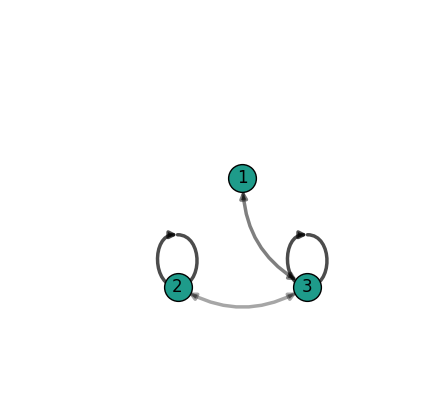

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_axis_off()
colors = sns.color_palette('viridis', n_colors=10).as_hex()
fake_circuits_cluster = np.array([
    [0, 0, -1],
    [0, 0, -1],
    [-1, -1, 0],
])
w = np.median(fake_circuits_cluster, axis=0)
create_network_inset(fig, ax,
                     pos=(0.0, 0.0),
                     width=1.2, height=0.9, edge_weights=make_nx_weights(
                         w, n_nodes=3,
                         vmin=-1, vmax=0),
                     node_color=colors[5], linewidth=2.5)